# TASK 1

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import json
from tqdm import tqdm

In [2]:
# Mounting Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/TestDataSet"
json_path = "/content/drive/MyDrive/TestDataSet/labels_list.json"

In [4]:
# Create a dictionary mapping indices to ImageNet labels
with open(json_path, "r") as f:
    index_map = json.load(f)
imagenet_labels = {i: int(entry.split(":")[0]) for i, entry in enumerate(index_map)}

# Define normalization values for pre-trained model compatibility
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [5]:

test_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-34 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval()

# Initialize counters for top-1 and top-5 accuracy
top1_correct = 0
top5_correct = 0
total = 0


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


In [6]:
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(device)
        targets = torch.tensor([imagenet_labels[t.item()] for t in targets]).to(device)

        outputs = model(images)# Get model predictions
        _, top5_preds = outputs.topk(5, dim=1)

        top1_correct += (top5_preds[:, 0] == targets).sum().item()# Update correct predictions counters
        top5_correct += sum([targets[i].item() in top5_preds[i].tolist() for i in range(len(targets))])
        total += targets.size(0)

100%|██████████| 16/16 [03:24<00:00, 12.76s/it]


In [7]:
# Calculate and print the top-1 and top-5 accuracy

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# TASK 2

In [8]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm

In [9]:
adv_dir = "/content/Adversarial_Test_Set_1"
os.makedirs(adv_dir, exist_ok=True)

In [10]:
mean = torch.tensor(mean_norms, device=device).view(1, 3, 1, 1).float()# Convert mean and std values to tensors
std = torch.tensor(std_norms, device=device).view(1, 3, 1, 1).float()

In [11]:
# FGSM (Fast Gradient Sign Method) attack function
def fgsm_attack_raw(model, images, labels, epsilon_raw):
    images_raw = images.clone().detach().requires_grad_(True)# Clone images and enable gradient tracking for perturbation calculation


    outputs = model((images_raw - mean) / std)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    perturbed_raw = images_raw + epsilon_raw * images_raw.grad.sign()
    perturbed_raw = torch.clamp(perturbed_raw, 0.0, 1.0)


    return (perturbed_raw - mean) / std# Return perturbed images after normalizing


# Set epsilon for the attack (perturbation magnitude)
epsilon = 0.02
adv_images, adv_labels = [], []


model.eval()# Set model to evaluation mode for inference
for idx, (images, targets_orig) in enumerate(tqdm(test_loader)):
    images = images.to(device)
    targets = torch.tensor([imagenet_labels[t.item()] for t in targets_orig]).to(device)


    images_raw = torch.clamp(images * std + mean, 0.0, 1.0)


    perturbed = fgsm_attack_raw(model, images_raw, targets, epsilon)

    # Check L∞ distance constraint
    diff_raw = ((perturbed * std + mean) - images_raw).abs()
    if diff_raw.max() > epsilon + 1e-6:
        print(f"[!] L∞ violation detected: max raw diff = {diff_raw.max().item():.4f}")


    for i in range(perturbed.size(0)):
        img = torch.clamp(perturbed[i] * std + mean, 0, 1)
        save_image(img.cpu(), f"{adv_dir}/img_{idx*32 + i:04d}.png")

    adv_images.append(perturbed.cpu())
    adv_labels.extend(targets.cpu().tolist())


adv_images = torch.cat(adv_images)
adv_dataset = TensorDataset(adv_images, torch.tensor(adv_labels))
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
# Evaluate the model on adversarial examples

top1_correct = top5_correct = total = 0
with torch.no_grad():
    for images, targets in tqdm(adv_loader):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)

        top1_correct += (top5_preds[:, 0] == targets).sum().item()
        top5_correct += sum(targets[i].item() in top5_preds[i] for i in range(len(targets)))
        total += targets.size(0)

print(f"Adversarial Top-1 Accuracy: {top1_correct / total * 100:.2f}%")
print(f"Adversarial Top-5 Accuracy: {top5_correct / total * 100:.2f}%")

100%|██████████| 16/16 [00:00<00:00, 16.83it/s]

Adversarial Top-1 Accuracy: 3.40%
Adversarial Top-5 Accuracy: 21.20%


In [12]:
# Function to display original and adversarial images along with the prediction differences

def show_images(orig, adv, labels, preds_before, preds_after):
    fig, axs = plt.subplots(5, 3, figsize=(12, 10))
    for i in range(5):
        img_o = orig[i].detach().cpu().permute(1, 2, 0).numpy()
        img_a = adv[i].detach().cpu().permute(1, 2, 0).numpy()
        diff = (adv[i] - orig[i]).abs().detach().cpu().permute(1, 2, 0).numpy() * 10

        axs[i, 0].imshow(img_o)
        axs[i, 0].set_title(f"Orig: {labels[i].item()}")
        axs[i, 1].imshow(img_a)
        axs[i, 1].set_title(f"Adv: {preds_after[i].item()}")
        axs[i, 2].imshow(diff)
        axs[i, 2].set_title("Diff ×10")
        for j in range(3):
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.show()

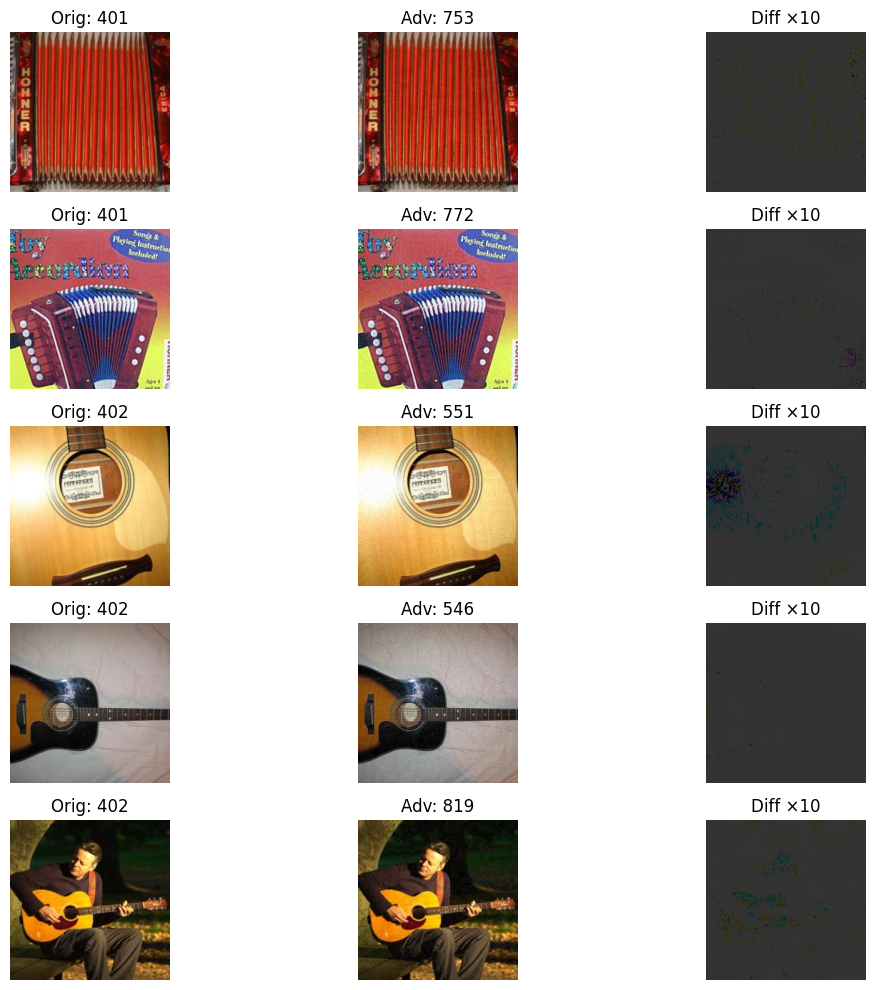

In [13]:
# Loop through the test dataset to evaluate adversarial attack effects
for images, targets_orig in test_loader:
    images = images.to(device)
    targets = torch.tensor([imagenet_labels[t.item()] for t in targets_orig]).to(device)


    unnormalized = torch.clamp(images * std + mean, 0.0, 1.0) # Denormalize images for adversarial perturbation calculation

    outputs_before = model(images)
    _, preds_before = outputs_before.topk(1, dim=1)


    adv_raw = fgsm_attack_raw(model, unnormalized, targets, epsilon)
    outputs_after = model(adv_raw)
    _, preds_after = outputs_after.topk(1, dim=1)


    diff_mask = (preds_before != preds_after).squeeze() # Create mask for where predictions have changed after the attack
    if diff_mask.sum() >= 5:
        idxs = diff_mask.nonzero(as_tuple=True)[0][:5]
        show_images(
            unnormalized[idxs],
            torch.clamp(adv_raw[idxs] * std + mean, 0.0, 1.0),
            targets[idxs],
            preds_before[idxs],
            preds_after[idxs]
        )
        break


# TASK 3


In [21]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
epsilon = 0.02
num_steps = 10
alpha = epsilon / num_steps


In [23]:
adv2_dir = "/content/Adversarial_Test_Set_2"
os.makedirs(adv2_dir, exist_ok=True)

In [24]:
mean = torch.tensor(mean_norms, device=device, dtype=torch.float32).view(1,3,1,1)
std  = torch.tensor(std_norms, device=device, dtype=torch.float32).view(1,3,1,1)

In [25]:
# PGD (Projected Gradient Descent) attack function
def pgd_attack(model, orig, labels, epsilon, alpha, num_steps):
    adv = orig.clone().detach().requires_grad_(True)
  # Iteratively apply small perturbations to the image

    for _ in range(num_steps):
        outputs = model((adv - mean) / std)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        adv = adv + alpha * adv.grad.sign() # Apply epsilon constraint
        adv = torch.max(torch.min(adv, orig + epsilon), orig - epsilon)
        adv = torch.clamp(adv, 0.0, 1.0)

        adv = adv.detach().requires_grad_(True)

    return adv.detach()

In [19]:
adv2_images = []
adv2_labels = []

model.eval()
for idx, (images, targets_orig) in enumerate(tqdm(test_loader)):
    images = images.to(device)
    targets = torch.tensor([imagenet_labels[t.item()] for t in targets_orig]).to(device)


    unnorm = torch.clamp(images * std + mean, 0.0, 1.0)


    adv_imgs = pgd_attack(model, unnorm, targets, epsilon, alpha, num_steps)

    # Check L∞ constraint
    diff = (adv_imgs - unnorm).abs()
    if diff.max() > epsilon + 1e-6:
        print(f"[!] L∞ violation detected: max diff = {diff.max().item()}")


    for i in range(adv_imgs.size(0)):
        save_image(adv_imgs[i].cpu(), f"{adv2_dir}/img_{idx * test_loader.batch_size + i:04d}.png")


    norm_adv = (adv_imgs - mean) / std

    adv2_images.append(norm_adv.cpu())
    adv2_labels.extend(targets.cpu().tolist())


100%|██████████| 16/16 [00:39<00:00,  2.49s/it]


In [20]:
# Create a DataLoader for the adversarial images and their labels


adv2_tensor = torch.cat(adv2_images)
adv2_dataset = TensorDataset(adv2_tensor, torch.tensor(adv2_labels))
adv2_loader = DataLoader(adv2_dataset, batch_size=32, shuffle=False)

In [ ]:
top1_corr = 0
top5_corr = 0
total = 0
# Evaluate the model on adversarial images and calculate top-1 and top-5 accuracy
with torch.no_grad():
    for imgs, lbls in tqdm(adv2_loader):
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        out = model(imgs)
        _, top5 = out.topk(5, dim=1)

        top1_corr += (top5[:, 0] == lbls).sum().item()
        top5_corr += sum([lbls[i].item() in top5[i].tolist() for i in range(len(lbls))])
        total += lbls.size(0)

print(f"🔻 PGD Top-1 Accuracy: {top1_corr / total * 100:.2f}%")
print(f"🔻 PGD Top-5 Accuracy: {top5_corr / total * 100:.2f}%")

100%|██████████| 16/16 [00:00<00:00, 16.90it/s]

🔻 PGD Top-1 Accuracy: 0.00%
🔻 PGD Top-5 Accuracy: 2.20%


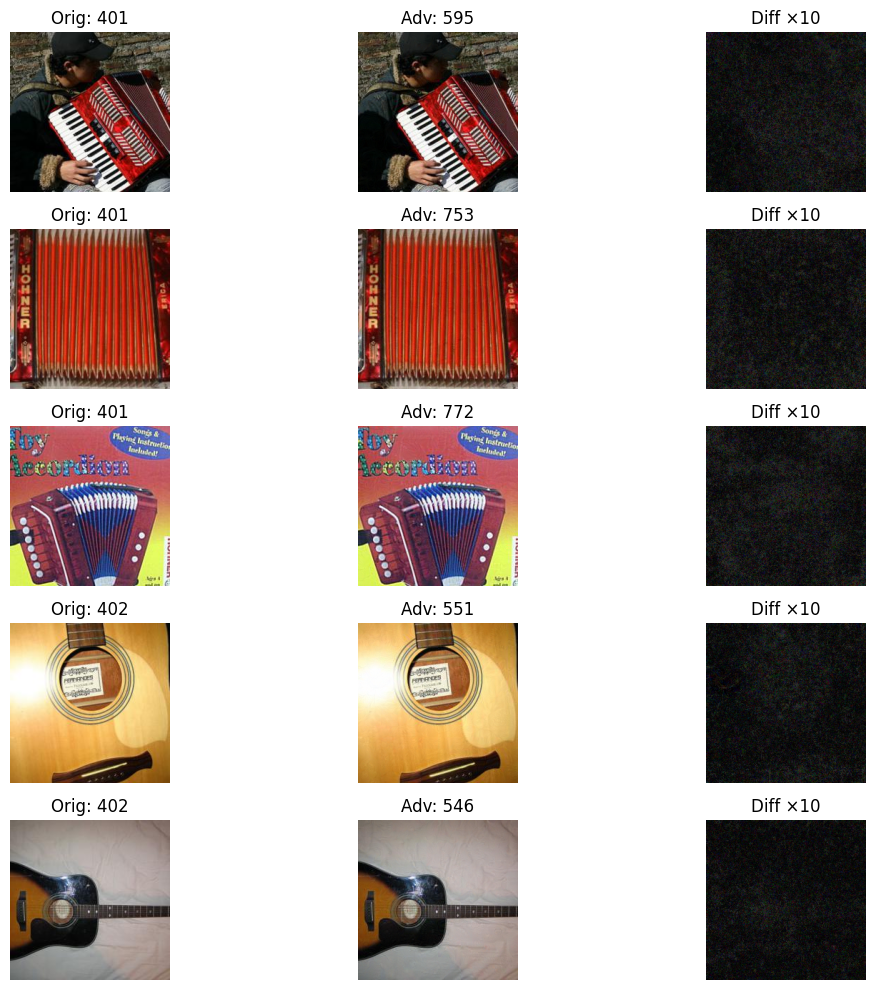

In [ ]:
# Function to display original, adversarial, and difference images for comparison
def show_adv(orig, adv, true, before, after):
    fig, axs = plt.subplots(5, 3, figsize=(12, 10))
    for i in range(5):
        o = orig[i].cpu().permute(1,2,0).numpy()
        a = adv[i].cpu().permute(1,2,0).numpy()
        d = ((adv[i] - orig[i]).abs() * 10).cpu().permute(1,2,0).numpy()

        axs[i,0].imshow(o); axs[i,0].set_title(f"Orig: {true[i].item()}")
        axs[i,1].imshow(a); axs[i,1].set_title(f"Adv: {after[i].item()}")
        axs[i,2].imshow(d); axs[i,2].set_title("Diff ×10")
        for j in range(3): axs[i,j].axis("off")
    plt.tight_layout(); plt.show()

# Loop through the test dataset to generate and visualize adversarial examples
for imgs, targets_orig in test_loader:
    imgs = imgs.to(device)
    targets = torch.tensor([imagenet_labels[t.item()] for t in targets_orig]).to(device)

    out_b = model(imgs); _, pred_b = out_b.topk(1, dim=1)

    unnorm = torch.clamp(imgs * std + mean, 0, 1)
    adv_imgs = pgd_attack(model, unnorm, targets, epsilon, alpha, num_steps)
    norm_adv = (adv_imgs - mean) / std

    out_a = model(norm_adv); _, pred_a = out_a.topk(1, dim=1)

    mask = (pred_b != pred_a).squeeze()
    if mask.sum() >= 5:
        idxs = mask.nonzero(as_tuple=True)[0][:5]
        show_adv(unnorm[idxs], adv_imgs[idxs], targets[idxs], pred_b[idxs], pred_a[idxs])
        break


# Task 4


In [26]:
import os, random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [27]:
patch_size = 32
epsilon    = 0.5
num_steps  = 60
alpha      = epsilon / num_steps
restarts   = 5

In [28]:
adv3_dir = "/content/Adversarial_Test_Set_3"
os.makedirs(adv3_dir, exist_ok=True)

In [29]:
mean = torch.tensor(mean_norms, device=device, dtype=torch.float32).view(1,3,1,1)
std  = torch.tensor(std_norms,  device=device, dtype=torch.float32).view(1,3,1,1)

In [30]:
# Prepare normalization tensors
mean = torch.tensor(mean_norms, device=device, dtype=torch.float32).view(1,3,1,1)
std  = torch.tensor(std_norms,  device=device, dtype=torch.float32).view(1,3,1,1)

def patch_pgd_multistart(model, orig, true_labels):
    """
    Applies PGD attack with multiple random patch starts.
    Returns the strongest adversarial examples found.
    """
    B, C, H, W = orig.shape
    best_adv = orig.clone()
    best_loss = torch.full((B,), -float('inf'), device=orig.device)

    for _ in range(restarts):
        # Random patch location for each image
        xs = [random.randint(0, W - patch_size) for _ in range(B)]
        ys = [random.randint(0, H - patch_size) for _ in range(B)]

        adv = orig.clone().detach().requires_grad_(True)

        for _ in range(num_steps):
            logits = model((adv - mean) / std)
            loss = F.cross_entropy(logits, true_labels, reduction='none')
            total_loss = loss.sum()

            model.zero_grad()
            total_loss.backward()

            grad_sign = adv.grad.sign().detach()
            mask = torch.zeros_like(adv)
            for i in range(B):
                mask[i, :, ys[i]:ys[i]+patch_size, xs[i]:xs[i]+patch_size] = 1.0

            # Apply gradient only inside the patch
            adv = adv + alpha * grad_sign * mask
            adv = torch.where(
                mask.bool(),
                torch.max(torch.min(adv, orig + epsilon), orig - epsilon),
                adv
            )
            adv = torch.clamp(adv, 0.0, 1.0)
            adv = adv.detach().requires_grad_(True)

        # Check L∞ constraint for the patched region
        diff = (adv - orig).abs()
        max_diff = (diff * mask).max()
        if max_diff > epsilon + 1e-6:
            print(f"[!] L∞ violation detected in patch: max diff = {max_diff.item():.4f}")

        # Keep the strongest attack per sample
        with torch.no_grad():
            logits = model((adv - mean) / std)
            loss_vals = F.cross_entropy(logits, true_labels, reduction='none')

        stronger = loss_vals > best_loss
        best_loss[stronger] = loss_vals[stronger]
        best_adv[stronger] = adv.detach()[stronger]

    return best_adv


In [31]:
# Generate and save adversarial examples using patch-based multi-restart PGD

adv3_images, adv3_labels = [], []

model.eval()
for idx, (images, targets_orig) in enumerate(tqdm(test_loader, desc="Gen Adv3")):
    images = images.to(device)
    true = torch.tensor([imagenet_labels[t.item()] for t in targets_orig]).to(device)


    unnorm = images * std + mean
    unnorm = torch.clamp(unnorm, 0.0, 1.0)


    adv_imgs = patch_pgd_multistart(model, unnorm, true)

    for i in range(adv_imgs.size(0)):
        save_image(adv_imgs[i].cpu(),
                   f"{adv3_dir}/img_{idx*test_loader.batch_size + i:04d}.png")


    norm_adv = (adv_imgs - mean) / std
    adv3_images.append(norm_adv.cpu())
    adv3_labels.extend(true.cpu().tolist())


adv3_tensor  = torch.cat(adv3_images)
adv3_dataset = TensorDataset(adv3_tensor, torch.tensor(adv3_labels))
adv3_loader  = DataLoader(adv3_dataset, batch_size=32, shuffle=False)


Gen Adv3: 100%|██████████| 16/16 [13:30<00:00, 50.66s/it]


In [32]:
# Evaluate model accuracy on PatchPGD adversarial examples

top1, top5, total = 0, 0, 0
with torch.no_grad():
    for imgs, lbls in tqdm(adv3_loader, desc="Eval Adv3"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        _, top5_preds = out.topk(5, dim=1)
        top1 += (top5_preds[:,0] == lbls).sum().item()
        top5 += sum([lbls[i].item() in top5_preds[i].tolist() for i in range(len(lbls))])
        total += lbls.size(0)

print(f"PatchPGD Top-1: {top1/total*100:.2f}%")
print(f"PatchPGD Top-5: {top5/total*100:.2f}%")

Eval Adv3: 100%|██████████| 16/16 [00:00<00:00, 17.68it/s]

PatchPGD Top-1: 5.00%
PatchPGD Top-5: 40.80%


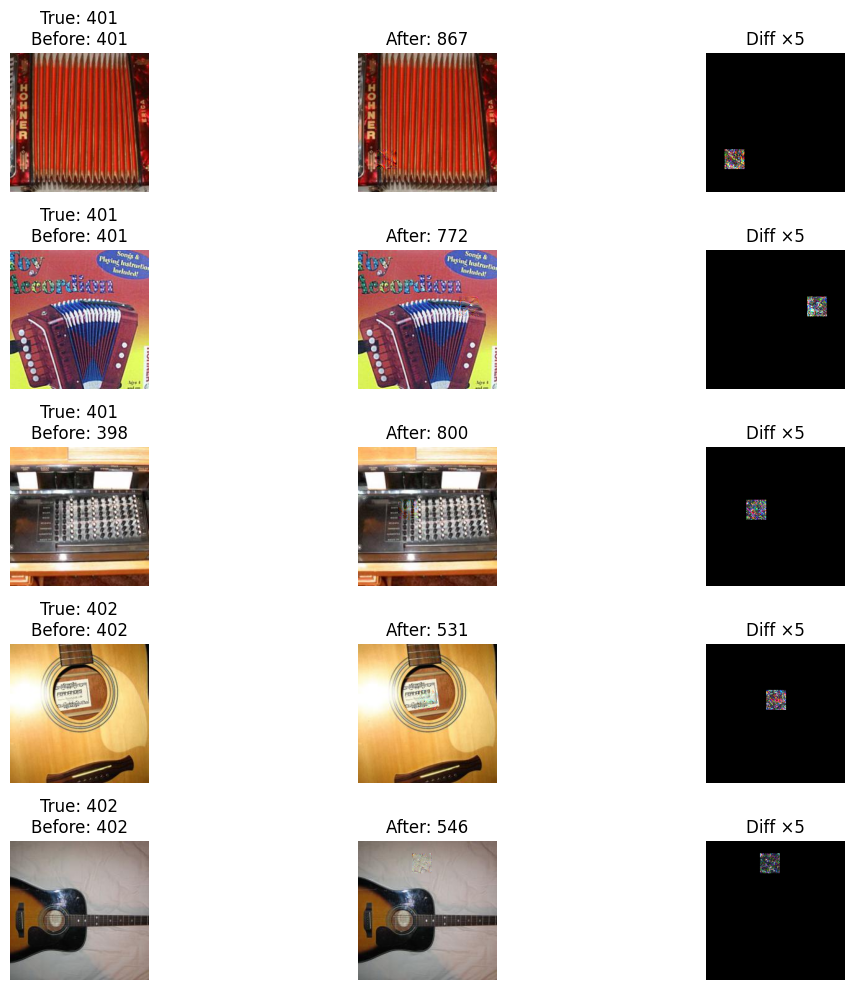

In [33]:
import matplotlib.pyplot as plt
# Visualize original vs PatchPGD adversarial images where predictions changed
def show_patch(orig, adv, true, before, after):
    fig, axs = plt.subplots(5, 3, figsize=(12, 10))
    for i in range(5):
        o = orig[i].cpu().permute(1, 2, 0).numpy()
        a = adv[i].cpu().permute(1, 2, 0).numpy()
        d = ((adv[i] - orig[i]).abs() * 5).cpu().permute(1, 2, 0).numpy()

        axs[i, 0].imshow(o)
        axs[i, 0].set_title(f"True: {true[i].item()}\nBefore: {before[i].item()}")
        axs[i, 1].imshow(a)
        axs[i, 1].set_title(f"After: {after[i].item()}")
        axs[i, 2].imshow(d)
        axs[i, 2].set_title("Diff ×5")

        for j in range(3):
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.show()

for imgs, targets_orig in test_loader:
    imgs = imgs.to(device)
    lbls = torch.tensor([imagenet_labels[t.item()] for t in targets_orig]).to(device)

    orig_unnorm = imgs * std + mean
    orig_unnorm = torch.clamp(orig_unnorm, 0.0, 1.0)


    out_b = model(imgs)
    _, pred_b = out_b.topk(1, dim=1)


    adv_imgs = patch_pgd_multistart(model, orig_unnorm, lbls)
    norm_adv = (adv_imgs - mean) / std


    out_a = model(norm_adv)
    _, pred_a = out_a.topk(1, dim=1)

    mask = (pred_b != pred_a).squeeze()
    if mask.sum() >= 5:
        idxs = mask.nonzero(as_tuple=True)[0][:5]
        show_patch(
            orig_unnorm[idxs],
            adv_imgs[idxs],
            lbls[idxs],
            pred_b[idxs],
            pred_a[idxs]
        )
        break

# TASK 5

In [34]:
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load label mapping from custom JSON

with open("/content/drive/MyDrive/TestDataSet/labels_list.json", "r") as f:
    index_map = json.load(f)
imagenet_labels = {i: int(entry.split(":")[0]) for i, entry in enumerate(index_map)}

# Normalization values and preprocessing pipeline


mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Load original dataset

orig_dataset = torchvision.datasets.ImageFolder(
    root="/content/drive/MyDrive/TestDataSet",
    transform=eval_transform
)
test_loader = DataLoader(orig_dataset, batch_size=32, shuffle=False)

# Load model for transferability testing

new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device).eval()

# Evaluation function (Top-1 and Top-5 accuracy)


def evaluate(loader, model, mapper=None):
    top1, top5, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, leave=False):
            images = images.to(device)
            if mapper is not None:
                labels = torch.tensor([mapper[int(l.item())] for l in labels],
                                      device=device)
            else:
                labels = labels.to(device)

            outputs = model(images)
            _, preds5 = outputs.topk(5, dim=1)
            top1 += (preds5[:, 0] == labels).sum().item()
            top5 += sum(labels[i].item() in preds5[i] for i in range(len(labels)))
            total += labels.size(0)
    return (top1 / total) * 100, (top5 / total) * 100

# Prepare adversarial image tensors if needed


if isinstance(adv_images, list):
    adv1_tensor = torch.cat(adv_images, dim=0)
else:
    adv1_tensor = adv_images

if isinstance(adv2_images, list):
    adv2_tensor = torch.cat(adv2_images, dim=0)
else:
    adv2_tensor = adv2_images

if isinstance(adv3_images, list):
    adv3_tensor = torch.cat(adv3_images, dim=0)
else:
    adv3_tensor = adv3_images


# Create loaders for adversarial test sets

adv_loader  = DataLoader(TensorDataset(adv1_tensor, torch.tensor(adv_labels)),
                         batch_size=32, shuffle=False)
adv2_loader = DataLoader(TensorDataset(adv2_tensor, torch.tensor(adv2_labels)),
                         batch_size=32, shuffle=False)
adv3_loader = DataLoader(TensorDataset(adv3_tensor, torch.tensor(adv3_labels)),
                         batch_size=32, shuffle=False)


# Run evaluation on the new model
print("=== Transferability to DenseNet-121 ===\n")


orig_t1, orig_t5 = evaluate(test_loader, new_model, mapper=imagenet_labels)
print(f"Original Test Set          → Top-1: {orig_t1:6.2f}%   Top-5: {orig_t5:6.2f}%")


for name, loader in [
    ("Adv Test Set 1 (FGSM)",     adv_loader),
    ("Adv Test Set 2 (PGD)",      adv2_loader),
    ("Adv Test Set 3 (PatchPGD)", adv3_loader)
]:
    t1, t5 = evaluate(loader, new_model, mapper=None)
    print(f"{name:25s} → Top-1: {t1:6.2f}%   Top-5: {t5:6.2f}%")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 118MB/s]


=== Transferability to DenseNet-121 ===



Original Test Set          → Top-1:  74.80%   Top-5:  93.60%


Adv Test Set 1 (FGSM)     → Top-1:  45.60%   Top-5:  76.20%


Adv Test Set 2 (PGD)      → Top-1:  48.00%   Top-5:  81.80%


Adv Test Set 3 (PatchPGD) → Top-1:  67.00%   Top-5:  89.60%


# Eval

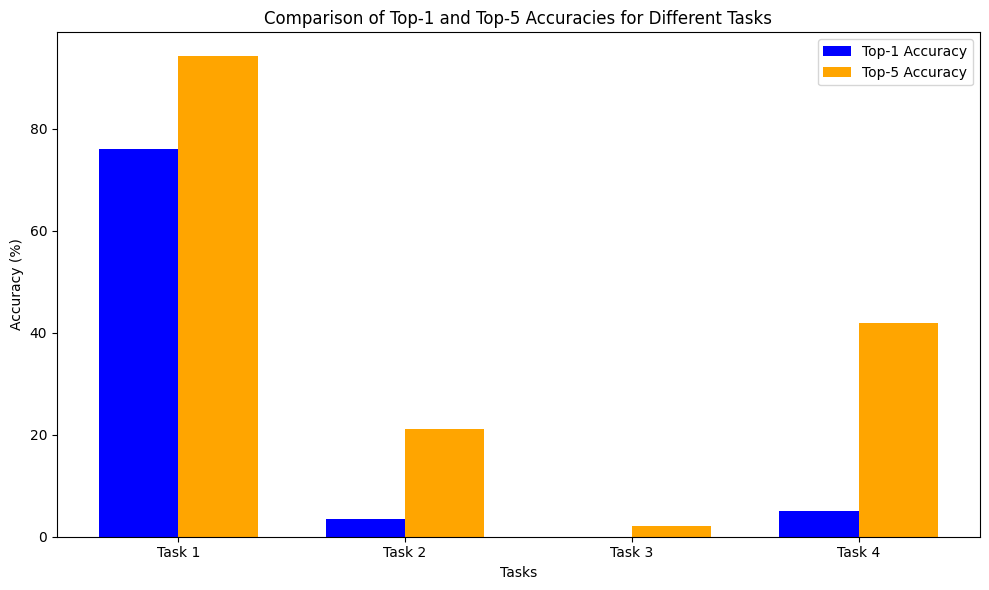

In [35]:
import matplotlib.pyplot as plt

# Bar chart comparing Top-1 and Top-5 classification accuracy across different adversarial tasks

# Task names and accuracy scores

attack_types = ['Task 1', 'Task 2', 'Task 3', 'Task 4']
top1_accuracies = [76.00, 3.40, 0.00, 5.00]
top5_accuracies = [94.20, 21.20, 2.20, 42.00]


x = range(len(attack_types))
width = 0.35


fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, top1_accuracies, width, label='Top-1 Accuracy', color='blue')
ax.bar([p + width for p in x], top5_accuracies, width, label='Top-5 Accuracy', color='orange')

# Labels and title
ax.set_xlabel('Tasks')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Top-1 and Top-5 Accuracies for Different Tasks')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(attack_types)
ax.legend()


plt.tight_layout()
plt.show()


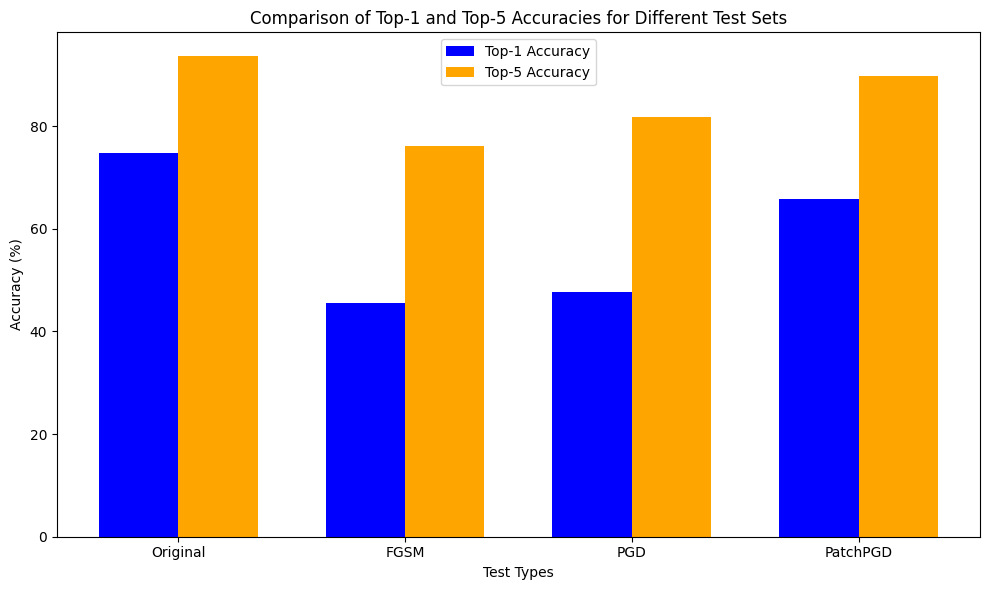

In [36]:
import matplotlib.pyplot as plt

#Bar chart comparing Top-1 and Top-5 accuracies on clean and adversarial test sets on tranfer model

attack_types = ['Original', 'FGSM', 'PGD', 'PatchPGD']
top1_accuracies = [74.80, 45.60, 47.60, 65.80]
top5_accuracies = [93.60, 76.20, 81.80, 89.80]


x = range(len(attack_types))
width = 0.35


fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, top1_accuracies, width, label='Top-1 Accuracy', color='blue')
ax.bar([p + width for p in x], top5_accuracies, width, label='Top-5 Accuracy', color='orange')

# X-ticks and legend
ax.set_xlabel('Test Types')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Top-1 and Top-5 Accuracies for Different Test Sets')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(attack_types)
ax.legend()


plt.tight_layout()
plt.show()


In [37]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("Adversarial_Test_Set_1", 'zip', "Adversarial_Test_Set_1")

# Download the zip
files.download("Adversarial_Test_Set_1.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("Adversarial_Test_Set_2", 'zip', "Adversarial_Test_Set_2")

# Download the zip
files.download("Adversarial_Test_Set_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("Adversarial_Test_Set_3", 'zip', "Adversarial_Test_Set_3")

# Download the zip
files.download("Adversarial_Test_Set_3.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>